In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
susandaneshmand_trash_images_path = kagglehub.dataset_download('susandaneshmand/trash-images')

print('Data source import complete.')


Data source import complete.


Consider a dataset containing images of various types of waste items categorized into different folders within the Data folder. We aim to create a model using Convolutional Neural Networks (CNNs) that can identify different types of waste items in various categories.

1. **Reading and categorizing images into training and testing datasets:** 200 points.
2. **Applying appropriate data augmentation techniques:** 200 points.
3. **Constructing a suitable CNN architecture:** 350 points.
4. **Tuning hyperparameter values for training:** 350 points.
5. **Performing model evaluation and analysis:** 100 points.

The starred items are optional and earn additional points:

1. **Performing data preprocessing using image processing techniques:** 50 points.
2. **Performing data augmentation using image processing techniques:** 50 points.
3. **Documenting methods to enhance model accuracy and the impact of hyperparameter adjustments, presented in a comprehensive PDF file:** 400 points.
4. **Creating an application for the trained model:** 250 points.
5. **Dockerizing the project:** 250 points.

In [2]:
%%capture
!pip install torchinfo
!pip install torchmetrics

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split as tts
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision.models import resnet50, ResNet50_Weights
from torchinfo import summary
from torchmetrics.classification import MulticlassAccuracy
from sklearn.metrics import confusion_matrix, classification_report
import os
from pathlib import Path
import random
from tqdm.auto import tqdm
from typing import Dict, List
import warnings
warnings.filterwarnings("ignore")


In [4]:
!pip install ImageDataGenerator

ERROR: Could not find a version that satisfies the requirement ImageDataGenerator (from versions: none)
ERROR: No matching distribution found for ImageDataGenerator


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Load data

In [6]:
# Let's see the number of images we have.
IMAGES_PATH = Path("/kaggle/input/trash-images/trash_images")

IMAGES_PATH_LIST = list(IMAGES_PATH.glob("*/*.jpg"))

print(f"Total Images = {len(IMAGES_PATH_LIST)}")

Total Images = 2527


In [7]:
# Let's look at the classes we have.
classes = os.listdir(IMAGES_PATH)
classes = sorted(classes)

print(f"Total classes = {len(classes)}")
print(f"Classes: {classes}")

Total classes = 6
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


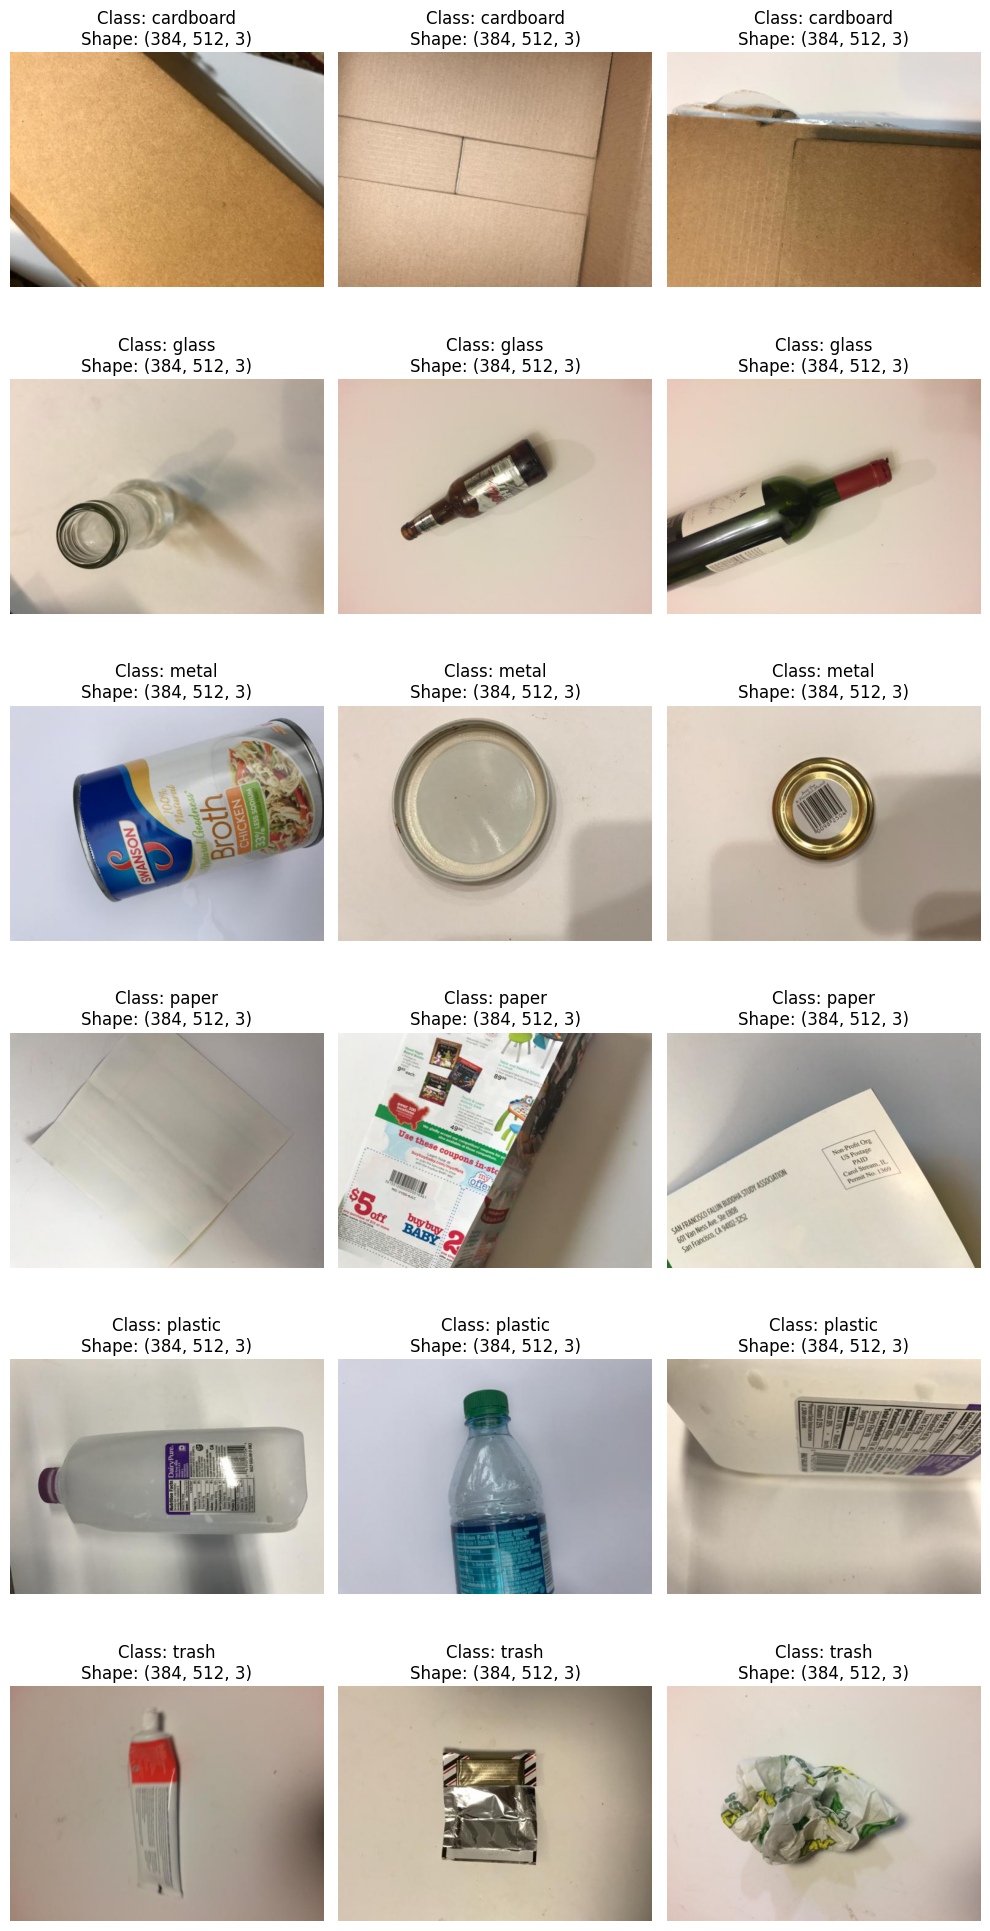

In [8]:
# Now let's visualize some images for each class.
NUM_IMAGES = 3
fig, ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10,20))
p = 0

for c in classes:
    imgs_path_list_class = list(Path(os.path.join(IMAGES_PATH, c)).glob("*.jpg"))
    imgs_selected = random.choices(imgs_path_list_class, k = NUM_IMAGES)
    for i,img_selected in enumerate(imgs_selected):
        img_bgr = cv2.imread(str(img_selected))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}")
        ax[p,i].axis("off")

    p += 1

fig.tight_layout()
fig.show()

In [9]:
# Let's find out the number of images per class.
print("**" * 20)
print(" " * 15, "Classes")
print("**" * 20)
for c in classes:
    imgs_path_list_class = list(Path(os.path.join(IMAGES_PATH, c)).glob("*.jpg"))
    print(f"* {c} => {len(imgs_path_list_class)} images\n")

****************************************
                Classes
****************************************
* cardboard => 403 images

* glass => 501 images

* metal => 410 images

* paper => 594 images

* plastic => 482 images

* trash => 137 images



# Preprocessing

In [10]:
import cv2
from pathlib import Path

# Function to normalize and denoise color images and replace them
def process_colored_images(image_path):
    # Read the original image in BGR format
    img_bgr = cv2.imread(str(image_path))

    # Normalize the color image
    normalized_image = cv2.normalize(img_bgr, None, 0, 255, cv2.NORM_MINMAX)

    # Reduce noise using a denoising method like bilateral filter
    denoised_image = cv2.bilateralFilter(normalized_image, 9, 75, 75)

    # Save the processed image back to the same file path (overwrite original)
    cv2.imwrite(str(image_path), denoised_image)

# Process, normalize, and denoise all colored images and replace them in the dataset
for image_path in IMAGES_PATH_LIST:
    process_colored_images(image_path)

# Confirmation message
print("All colored images have been normalized, denoised, and replaced in the dataset.")

All colored images have been normalized, denoised, and replaced in the dataset.


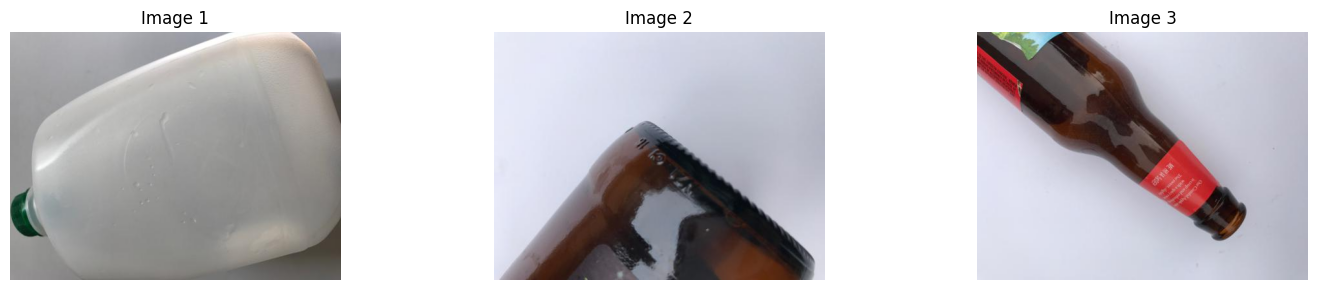

In [11]:
import cv2
import random
import matplotlib.pyplot as plt

# Randomly select a subset of colored images for plotting
NUM_IMAGES_TO_PLOT = 3
selected_images = random.sample(IMAGES_PATH_LIST, NUM_IMAGES_TO_PLOT)

# Plot the selected colored images
fig, ax = plt.subplots(1, NUM_IMAGES_TO_PLOT, figsize=(15, 3))

for i, image_path in enumerate(selected_images):
    colored_image = cv2.imread(str(image_path), cv2.IMREAD_COLOR)  # Read the image in color
    colored_image_rgb = cv2.cvtColor(colored_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying with matplotlib
    ax[i].imshow(colored_image_rgb)
    ax[i].set_title(f"Image {i + 1}")
    ax[i].axis("off")

plt.tight_layout()
plt.show()

In [12]:
# import cv2
# from pathlib import Path
# import os

# # Function to convert and replace images to grayscale
# def convert_to_grayscale_and_replace(image_path):
#     # Read the original image in BGR format
#     img_bgr = cv2.imread(str(image_path))

#     # Convert the image to grayscale
#     grayscale_image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

#     # Save the grayscale image back to the same file path (overwrite original)
#     cv2.imwrite(str(image_path), grayscale_image)

# # Convert all images to grayscale and replace them in the dataset
# for image_path in IMAGES_PATH_LIST:
#     convert_to_grayscale_and_replace(image_path)

# # Confirmation message
# print("All images have been converted to grayscale and replaced in the dataset.")

In [13]:
# # Randomly select a subset of grayscale images for plotting
# NUM_IMAGES_TO_PLOT = 3
# selected_images = random.sample(IMAGES_PATH_LIST, NUM_IMAGES_TO_PLOT)

# # Plot the selected grayscale images
# fig, ax = plt.subplots(1, NUM_IMAGES_TO_PLOT, figsize=(15, 3))

# for i, image_path in enumerate(selected_images):
#     grayscale_image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
#     ax[i].imshow(grayscale_image, cmap='gray')
#     ax[i].set_title(f"Image {i + 1}")
#     ax[i].axis("off")

# plt.tight_layout()
# plt.show()

In [14]:
# We create a pd.DataFrame where we store the paths and labels of each image.
imgs_path = [None] * len(IMAGES_PATH_LIST)
label = [None] * len(IMAGES_PATH_LIST)

for i, image_path in enumerate(IMAGES_PATH_LIST):
    imgs_path[i] = image_path
    label[i] = image_path.parent.stem

df_path_label = pd.DataFrame({"path":imgs_path,
                              "label":label})
df_path_label.head()

,path,label
0,/kaggle/input/trash-images/trash_images/metal/...,metal
1,/kaggle/input/trash-images/trash_images/metal/...,metal
2,/kaggle/input/trash-images/trash_images/metal/...,metal
3,/kaggle/input/trash-images/trash_images/metal/...,metal
4,/kaggle/input/trash-images/trash_images/metal/...,metal


In [15]:
# Now we have to divide into training and test set.
# But first we define our random seed for reproducibility.
SEED = 42
df_train, df_test = tts(df_path_label,
                        test_size = 0.3,
                        random_state = SEED,
                        stratify = df_path_label["label"])

In [16]:
# Assuming df_train and df_test are your pandas DataFrames containing the data
number_of_rows_train = len(df_train)
number_of_rows_test = len(df_test)

print(f"Number of rows in df_train: {number_of_rows_train}")
print(f"Number of rows in df_test: {number_of_rows_test}")

Number of rows in df_train: 1768
Number of rows in df_test: 759


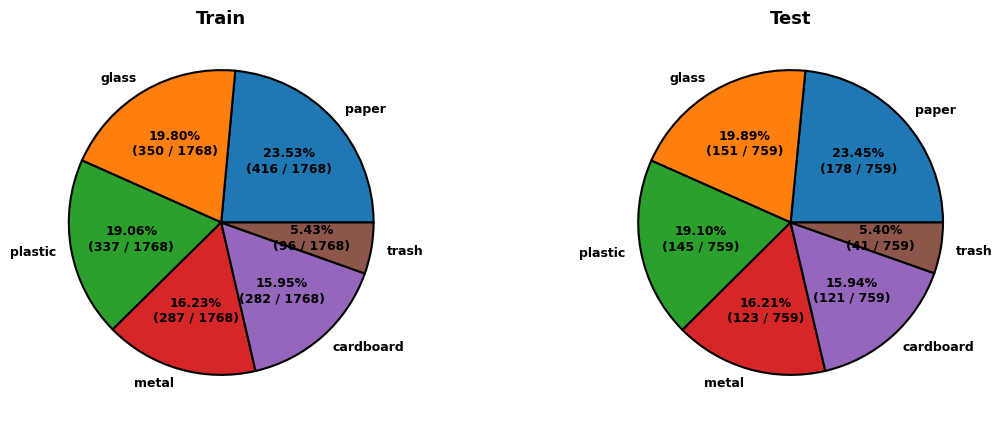

In [17]:
# Visualization of the target variable distribution in the training and test sets
df_pct_train = df_train['label'].value_counts().to_frame()
labels_train = df_pct_train.index.to_list()
values_train = df_pct_train.iloc[:, 0]

df_pct_test = df_test['label'].value_counts().to_frame()
labels_test = df_pct_test.index.to_list()
values_test = df_pct_test.iloc[:, 0]

total_train_samples = len(df_train)
total_test_samples = len(df_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.4))

def autopct_func(abs_values, total_samples):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.2f}%\n({next(gen)} / {total_samples})"

axes[0].pie(x=values_train, labels=labels_train, autopct=autopct_func(values_train, total_train_samples),
            wedgeprops={'linewidth': 1.5, 'edgecolor': 'black'},
            textprops={'fontsize': 9, 'fontweight': 'bold'})
axes[0].set_title('Train', fontsize=13, fontweight='bold', color='black')

axes[1].pie(x=values_test, labels=labels_test, autopct=autopct_func(values_test, total_test_samples),
            wedgeprops={'linewidth': 1.5, 'edgecolor': 'black'},
            textprops={'fontsize': 9, 'fontweight': 'bold'})
axes[1].set_title('Test', fontsize=13, fontweight='bold', color='black')

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

# Data Augmentation

## Increasing the Number of Training Samples

In [18]:
# Define a function for image augmentation using Keras ImageDataGenerator
def augment_image(image_path, save_path):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Ensure image_path is a string
    image_path = str(image_path)

    original_image = cv2.imread(image_path)
    original_image = np.expand_dims(original_image, axis=0)

    # Configure the generator to augment the image

    # Generate augmented images
    aug_iter = datagen.flow(original_image, save_to_dir=os.path.dirname(save_path),
                        save_prefix='augmented_', save_format='jpg')
    aug_image = next(aug_iter)[0].astype(np.uint8)

    # Save the augmented image
    cv2.imwrite(save_path, aug_image)
    return save_path

# Example: Augmenting images in df_train and saving augmented images
augmented_image_paths = []  # Store paths of augmented images

for index, row in df_train.iterrows():
    original_image_path = row['path']

    # Specify the path to save the augmented image
    save_path = f'augmented_image_{index}.jpg'

    # Augment and save the image
    augmented_path = augment_image(original_image_path, save_path)
    augmented_image_paths.append(augmented_path)  # Store the path for further use

# Create a new DataFrame for augmented images
augmented_df = pd.DataFrame({
    'path': augmented_image_paths,
    'label': df_train['label']  # Use the corresponding label from df_train
})

# Concatenate the augmented DataFrame with original df_train
df_train = pd.concat([df_train, augmented_df], ignore_index=True)

## Balancing the Training Set

In [19]:
# # Define a function for image augmentation using Keras ImageDataGenerator
# def augment_image(image_path, save_path):
#     datagen = ImageDataGenerator(
#         rotation_range=10,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         shear_range=0.2,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         fill_mode='nearest'
#     )

#     # Ensure image_path is a string
#     image_path = str(image_path)

#     original_image = cv2.imread(image_path)
#     original_image = np.expand_dims(original_image, axis=0)

#     # Configure the generator to augment the image
#     aug_iter = datagen.flow(original_image, save_to_dir=os.path.dirname(save_path),
#                             save_prefix='augmented_', save_format='jpg')

#     # Generate augmented images
#     aug_image = aug_iter.next()[0].astype(np.uint8)

#     # Save the augmented image
#     cv2.imwrite(save_path, aug_image)
#     return save_path

# # Desired number of samples per class
# target_samples_per_class = 500

# # Dictionary to store augmented image paths for each class
# augmented_image_paths_by_class = {}

# # Loop through unique classes in the original DataFrame
# for label in df_train['label'].unique():
#     class_samples = df_train[df_train['label'] == label]
#     num_existing_samples = len(class_samples)
#     num_augmented_samples_needed = target_samples_per_class - num_existing_samples

#     # List to store augmented image paths for the current class
#     augmented_image_paths = []

#     # Augment images until the desired number of samples is reached
#     for index, row in class_samples.iterrows():
#         original_image_path = row['path']
#         save_path = f'augmented_image_{index}.jpg'
#         augmented_path = augment_image(original_image_path, save_path)
#         augmented_image_paths.append(augmented_path)

#     # Generate additional augmented images if needed
#     for i in range(num_augmented_samples_needed):
#         # Choose a random existing sample for augmentation
#         random_index = np.random.randint(0, len(class_samples))
#         random_row = class_samples.iloc[random_index]
#         original_image_path = random_row['path']
#         save_path = f'augmented_image_{len(df_train) + i}.jpg'
#         augmented_path = augment_image(original_image_path, save_path)
#         augmented_image_paths.append(augmented_path)

#     # Store augmented image paths for the current class
#     augmented_image_paths_by_class[label] = augmented_image_paths

# # Concatenate augmented image paths into a single list
# augmented_image_paths = []
# for _, paths in augmented_image_paths_by_class.items():
#     augmented_image_paths.extend(paths)

# # Create a DataFrame for augmented images
# augmented_df = pd.DataFrame({
#     'path': augmented_image_paths,
#     'label': df_train['label'].repeat(target_samples_per_class)  # Repeat labels for each sample
# })

# # Concatenate the augmented DataFrame with original df_train
# df_train = pd.concat([df_train, augmented_df], ignore_index=True)


In [20]:
# Assuming df_train is your pandas DataFrame containing the data
number_of_rows = len(df_train)
print(f"Number of rows in df_train: {number_of_rows}")

Number of rows in df_train: 3536


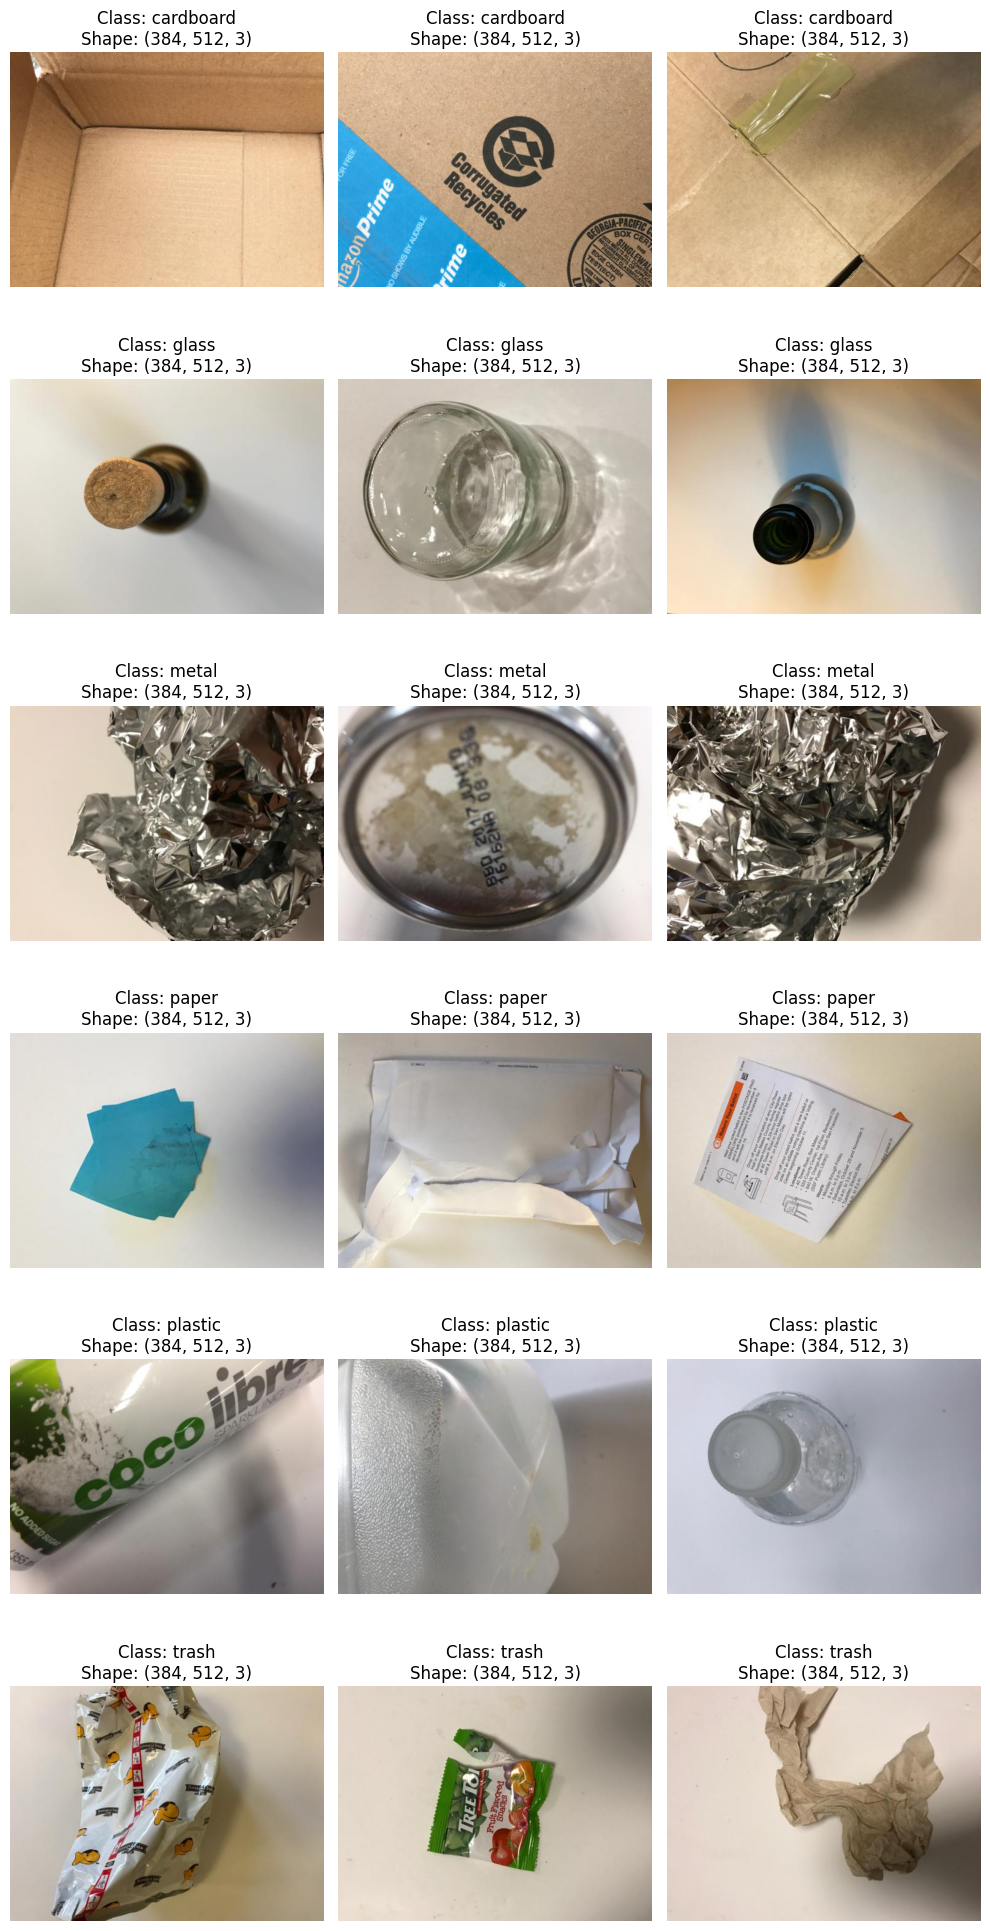

In [21]:
# Set the number of images to display for each class
NUM_IMAGES = 3

# Create subplots for each class and display a few images
fig, ax = plt.subplots(nrows=len(classes), ncols=NUM_IMAGES, figsize=(10, 20))
p = 0

# Iterate through each class
for c in classes:
    # Get a list of image paths for the current class
    imgs_path_list_class = list(Path(os.path.join(IMAGES_PATH, c)).glob("*.jpg"))

    # Randomly select a few images from the class
    imgs_selected = random.choices(imgs_path_list_class, k=NUM_IMAGES)

    # Display the selected images in the subplot
    for i, img_selected in enumerate(imgs_selected):
        img_bgr = cv2.imread(str(img_selected))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # Show the image with class label and image shape
        ax[p, i].imshow(img_rgb)
        ax[p, i].set_title(f"Class: {c}\nShape: {img_rgb.shape}")
        ax[p, i].axis("off")

    p += 1

# Adjust layout and display the plot
fig.tight_layout()
plt.show()

In [22]:
# # Convert all images to grayscale and replace them in the dataset
# for image_path in IMAGES_PATH_LIST:
#     convert_to_grayscale_and_replace(image_path)

# # Randomly select a subset of grayscale images for plotting
# NUM_IMAGES_TO_PLOT = 5
# selected_images = random.sample(IMAGES_PATH_LIST, NUM_IMAGES_TO_PLOT)

# # Plot the selected grayscale images
# fig, ax = plt.subplots(1, NUM_IMAGES_TO_PLOT, figsize=(15, 3))

# for i, image_path in enumerate(selected_images):
#     grayscale_image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
#     ax[i].imshow(grayscale_image, cmap='gray')
#     ax[i].set_title(f"Image {i + 1}")
#     ax[i].axis("off")

# plt.tight_layout()
# plt.show()

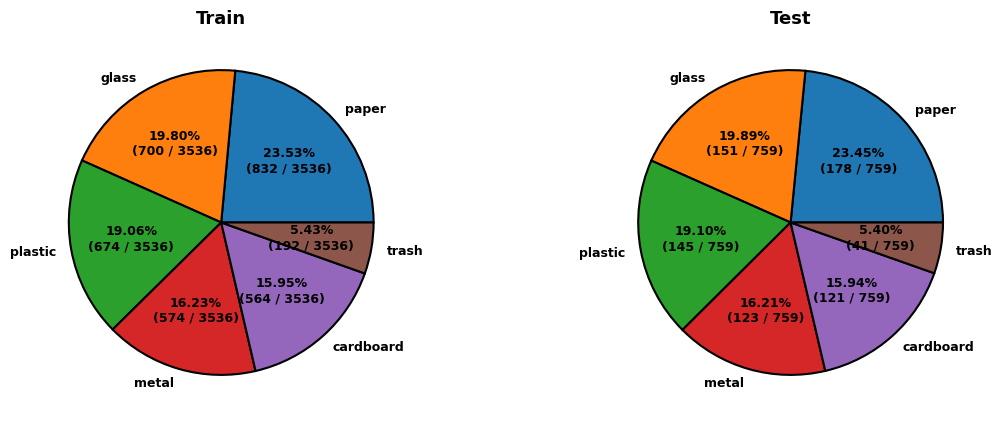

In [23]:
# Visualization of the target variable distribution in the training and test sets
df_pct_train = df_train['label'].value_counts().to_frame()
labels_train = df_pct_train.index.to_list()
values_train = df_pct_train.iloc[:, 0]

df_pct_test = df_test['label'].value_counts().to_frame()
labels_test = df_pct_test.index.to_list()
values_test = df_pct_test.iloc[:, 0]

total_train_samples = len(df_train)
total_test_samples = len(df_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.4))

def autopct_func(abs_values, total_samples):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.2f}%\n({next(gen)} / {total_samples})"

axes[0].pie(x=values_train, labels=labels_train, autopct=autopct_func(values_train, total_train_samples),
            wedgeprops={'linewidth': 1.5, 'edgecolor': 'black'},
            textprops={'fontsize': 9, 'fontweight': 'bold'})
axes[0].set_title('Train', fontsize=13, fontweight='bold', color='black')

axes[1].pie(x=values_test, labels=labels_test, autopct=autopct_func(values_test, total_test_samples),
            wedgeprops={'linewidth': 1.5, 'edgecolor': 'black'},
            textprops={'fontsize': 9, 'fontweight': 'bold'})
axes[1].set_title('Test', fontsize=13, fontweight='bold', color='black')

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [24]:
# Now we define a mapping to convert the labels into number.
label_map = dict(zip(classes, range(0,len(classes))))
label_map

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [25]:
# We apply the mapping to our previously created training and testing dataframe.
df_train["label"] = df_train["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)

In [26]:
# Reset the indices of our dataframes to maintain order and not have
# problems when we create our Dataset's.
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [27]:
# Now we have to define the transformations that we will make to our images.
weights = ResNet50_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

# Dataset

In [28]:
class CustomDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transforms):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx, 0]
        image = Image.open(image_path)
        label = self.df.iloc[idx, 1]
        image = self.transforms(image)
        return image,label

In [29]:
train_dataset = CustomDataset(df_train, auto_transforms)
test_dataset = CustomDataset(df_test, auto_transforms)

# Data Loader

In [30]:
BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False,
                             num_workers = NUM_WORKERS)

In [31]:
# Let's visualize a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

# Model

In [32]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [33]:
# We define the model to use with the pretrained weights.
model = resnet50(weights = weights)

In [34]:
# Let's take a look at the architecture of the model.
summary(model = model,
        input_size = [4, 3, 224, 224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 17,
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [4, 3, 224, 224]  [4, 1000]         --                True
├─Conv2d (conv1)                         [4, 3, 224, 224]  [4, 64, 112, 112] 9,408             True
├─BatchNorm2d (bn1)                      [4, 64, 112, 112] [4, 64, 112, 112] 128               True
├─ReLU (relu)                            [4, 64, 112, 112] [4, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [4, 64, 112, 112] [4, 64, 56, 56]   --                --
├─Sequential (layer1)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                True
│    └─Bottleneck (0)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                True
│    │    └─Conv2d (conv1)               [4, 64, 56, 56]   [4, 64, 56, 56]   4,096             True
│    │    └─BatchNorm2d (bn1)            [4, 64, 56, 56]   [4, 64, 56, 56]   128               True

In [35]:
for param in model.parameters():
    param.requires_grad = False

In [36]:
# Let's see if the extractor layers froze.
summary(model = model,
        input_size = [4, 3, 224, 224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 17,
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [4, 3, 224, 224]  [4, 1000]         --                False
├─Conv2d (conv1)                         [4, 3, 224, 224]  [4, 64, 112, 112] (9,408)           False
├─BatchNorm2d (bn1)                      [4, 64, 112, 112] [4, 64, 112, 112] (128)             False
├─ReLU (relu)                            [4, 64, 112, 112] [4, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [4, 64, 112, 112] [4, 64, 56, 56]   --                --
├─Sequential (layer1)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                False
│    └─Bottleneck (0)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                False
│    │    └─Conv2d (conv1)               [4, 64, 56, 56]   [4, 64, 56, 56]   (4,096)           False
│    │    └─BatchNorm2d (bn1)            [4, 64, 56, 56]   [4, 64, 56, 56]   (128)           

In [37]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [38]:
output_shape = len(classes)

model.fc = nn.Linear(in_features = 2048, out_features = output_shape, bias = True)

In [39]:
# Finally, let's see how our model looked after modifying the last layer.
summary(model = model,
        input_size = [4, 3, 224, 224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 17,
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [4, 3, 224, 224]  [4, 6]            --                Partial
├─Conv2d (conv1)                         [4, 3, 224, 224]  [4, 64, 112, 112] (9,408)           False
├─BatchNorm2d (bn1)                      [4, 64, 112, 112] [4, 64, 112, 112] (128)             False
├─ReLU (relu)                            [4, 64, 112, 112] [4, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [4, 64, 112, 112] [4, 64, 56, 56]   --                --
├─Sequential (layer1)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                False
│    └─Bottleneck (0)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                False
│    │    └─Conv2d (conv1)               [4, 64, 56, 56]   [4, 64, 56, 56]   (4,096)           False
│    │    └─BatchNorm2d (bn1)            [4, 64, 56, 56]   [4, 64, 56, 56]   (128)         

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [41]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    accuracy_train = MulticlassAccuracy(num_classes = len(classes)).to(device)

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()


        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        accuracy_train.update(y_pred_prob, y)

    train_loss = train_loss/len(dataloader)
    train_accuracy = accuracy_train.compute()

    accuracy_train.reset()

    return train_loss, train_accuracy

In [42]:
def save_checkpoint(filename, model, loss, epoch, metric, optimizer):

    state = {"filename":filename,
             "model":model.state_dict(),
             "loss":loss,
             "epoch":epoch,
             "metric":metric,
             "optimizer":optimizer.state_dict()}

    torch.save(state, filename)

In [43]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

    model.eval()

    test_loss = 0.
    accuracy_test = MulticlassAccuracy(num_classes = len(classes)).to(device)

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            test_loss += loss.item()

            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            accuracy_test.update(y_pred_prob, y)

    test_loss = test_loss/len(dataloader)
    test_accuracy = accuracy_test.compute()

    accuracy_test.reset()

    return test_loss, test_accuracy

In [44]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epochs:int = 10):

    results = {"train_loss":[],
               "train_accuracy":[],
               "test_loss":[],
               "test_accuracy":[]}

    best_test_loss = float("inf")

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model,
                                                dataloader = train_dataloader,
                                                loss_fn = loss_fn,
                                                optimizer = optimizer)

        test_loss, test_accuracy = test_step(model = model,
                                             dataloader = test_dataloader,
                                             loss_fn = loss_fn)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            file_name = "best_model.pt"
            save_checkpoint(file_name,
                            model,
                            best_test_loss,
                            epoch,
                            test_accuracy,
                            optimizer)

        print(f"Epoch: {epoch + 1} | ",
              f"Train Loss: {train_loss:.4f} | ",
              f"Train Accuracy: {train_accuracy:.4f} | ",
              f"Test Loss: {test_loss:.4f} | ",
              f"Test Accuracy: {test_accuracy:.4f}")

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)

    return results

In [46]:
# We execute the training!!!
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

EPOCHS = 30

MODEL_RESULTS = train(model.to(device),
                      train_dataloader,
                      test_dataloader,
                      loss_fn,
                      optimizer,
                      EPOCHS)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.5675 |  Train Accuracy: 0.8774 |  Test Loss: 1.1804 |  Test Accuracy: 0.8553
Epoch: 2 |  Train Loss: 0.6217 |  Train Accuracy: 0.8603 |  Test Loss: 1.1595 |  Test Accuracy: 0.8267
Epoch: 3 |  Train Loss: 0.5211 |  Train Accuracy: 0.8784 |  Test Loss: 1.0607 |  Test Accuracy: 0.8449
Epoch: 4 |  Train Loss: 0.6097 |  Train Accuracy: 0.8687 |  Test Loss: 1.7479 |  Test Accuracy: 0.8288
Epoch: 5 |  Train Loss: 0.5843 |  Train Accuracy: 0.8762 |  Test Loss: 1.6740 |  Test Accuracy: 0.8476
Epoch: 6 |  Train Loss: 0.5714 |  Train Accuracy: 0.8739 |  Test Loss: 1.5151 |  Test Accuracy: 0.7989
Epoch: 7 |  Train Loss: 0.5939 |  Train Accuracy: 0.8702 |  Test Loss: 1.4040 |  Test Accuracy: 0.7926
Epoch: 8 |  Train Loss: 0.5833 |  Train Accuracy: 0.8791 |  Test Loss: 1.2419 |  Test Accuracy: 0.8174
Epoch: 9 |  Train Loss: 0.5230 |  Train Accuracy: 0.8904 |  Test Loss: 1.2960 |  Test Accuracy: 0.8086
Epoch: 10 |  Train Loss: 0.5432 |  Train Accuracy: 0.8861 |  Test Loss: 1

In [60]:
# Save the model after training
torch.save({
    'epoch': EPOCHS - 1,  # Last epoch
    'model_state_dict': model.state_dict(),
    'loss': 0.0,  # Replace with actual loss if available
    'metric': 0.0  # Replace with actual metric if tracked
}, "/kaggle/working/best_model.pt")


In [55]:
torch.save(model.state_dict(), "best_model.pt")


In [51]:
checkpoint_path = "best_model.pt"
checkpoint = torch.load(checkpoint_path)


In [47]:
# Function to plot the loss and metric during each training epoch.
def plot_loss_metric_curve(model_results:Dict[str,List[float]]):

    train_loss = model_results["train_loss"]
    test_loss = model_results["test_loss"]

    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    test_accuracy = [float(value) for value in model_results["test_accuracy"]]

    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    plt.style.use("ggplot")
    axes = axes.flat

    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(test_loss, color = "blue", label = "Test")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()

    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(test_accuracy, color = "blue", label = "Test")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()

    fig.tight_layout()
    fig.show()

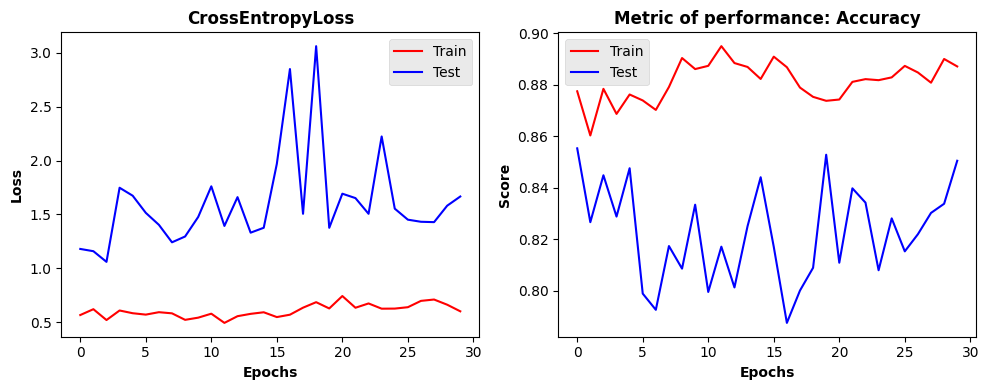

In [48]:
plot_loss_metric_curve(MODEL_RESULTS)

## Data augmentation was applied to the training set, but it did not result in improved performance. Conversely, the test set, which was not augmented, showed performance improvement over the course of the epochs.

# Predictions

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [61]:
# Let's load the best model.
checkpoint_path = "/kaggle/working/best_model.pt"
checkpoint = torch.load(checkpoint_path)

In [68]:
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [69]:
print(f"Best loss: {checkpoint['loss']}")
print(f"Epoch: {checkpoint['epoch'] + 1}")
print(f"Metric: {checkpoint['metric']}")

Best loss: 0.0
Epoch: 30
Metric: 0.0


In [63]:
print("Train DataLoader Details:")
print("Batch Size:", train_dataloader.batch_size)
print("Number of Batches:", len(train_dataloader))
print("Number of Workers:", train_dataloader.num_workers)
print("Drop Last:", train_dataloader.drop_last)

Train DataLoader Details:
Batch Size: 4
Number of Batches: 884
Number of Workers: 2
Drop Last: False


In [70]:
checkpoint = torch.load('/kaggle/working/best_model.pt', map_location=torch.device('cpu'))

model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

y_pred_train = []
y_pred_test = []

with torch.inference_mode():
    for X_train, y_train in train_dataloader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        y_pred_logit_train = model(X_train)
        y_pred_prob_train = torch.softmax(y_pred_logit_train, dim=1)
        y_pred_class_train = torch.argmax(y_pred_prob_train, dim=1)
        y_pred_train.append(y_pred_class_train)

    for X_test, y_test in test_dataloader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred_logit_test = model(X_test)
        y_pred_prob_test = torch.softmax(y_pred_logit_test, dim=1)
        y_pred_class_test = torch.argmax(y_pred_prob_test, dim=1)
        y_pred_test.append(y_pred_class_test)


In [71]:
y_pred_train = torch.cat(y_pred_train).cpu().numpy()
y_pred_test = torch.cat(y_pred_test).cpu().numpy()

# Confusion Matrix

In [72]:
y_train = np.array(df_train["label"])
y_test = np.array(df_test["label"])

In [73]:
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)

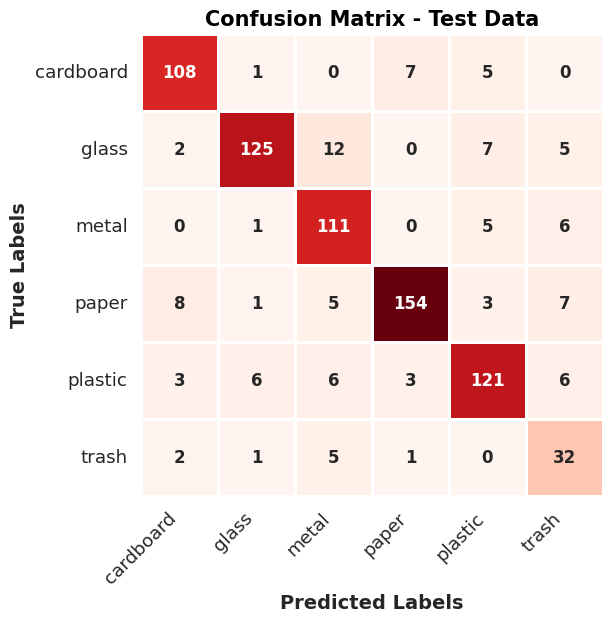

In [74]:
# Confusion Matrix Plot for Test Data
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix_test,
            cmap='Reds',
            annot=True,
            fmt='d',
            annot_kws={"fontsize": 12, "fontweight": "bold"},
            linewidths=1,
            linecolor="white",
            cbar=False,
            square=True,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
plt.ylabel('True Labels', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix - Test Data', fontsize=15, fontweight='bold', color='black')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Classification Report

In [75]:
# We create a reverse mapping to go from number to text.
id2label = dict(zip(range(0,len(classes)), classes))
id2label

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [76]:
print("=="*40)
print(" " * 25, "Classification Report Test")
print("=="*40)
print(classification_report(pd.Series(y_test).map(id2label),
                            pd.Series(y_pred_test).map(id2label)))

                          Classification Report Test
              precision    recall  f1-score   support

   cardboard       0.88      0.89      0.89       121
       glass       0.93      0.83      0.87       151
       metal       0.80      0.90      0.85       123
       paper       0.93      0.87      0.90       178
     plastic       0.86      0.83      0.85       145
       trash       0.57      0.78      0.66        41

    accuracy                           0.86       759
   macro avg       0.83      0.85      0.84       759
weighted avg       0.87      0.86      0.86       759



Here's a breakdown of the metrics:

### Precision:
- **Cardboard:** 0.86
- **Glass:** 0.79
- **Metal:** 0.87
- **Paper:** 0.92
- **Plastic:** 0.86
- **Trash:** 0.48

Precision represents the proportion of true positive predictions among all positive predictions made by the model. For example, for the class "Cardboard," 86% of the predicted Cardboard items were correct.

### Recall:
- **Cardboard:** 0.88
- **Glass:** 0.93
- **Metal:** 0.77
- **Paper:** 0.80
- **Plastic:** 0.80
- **Trash:** 0.71

Recall (or sensitivity) measures the proportion of true positives that were correctly predicted by the model. For instance, the model captured 93% of all Glass items present in the dataset.

### F1-Score:
- **Cardboard:** 0.87
- **Glass:** 0.85
- **Metal:** 0.82
- **Paper:** 0.86
- **Plastic:** 0.83
- **Trash:** 0.57

The F1-score is the harmonic mean of precision and recall and provides a balance between the two metrics. Higher F1-scores indicate better performance. For instance, the F1-score for "Glass" is 0.85, which is a good balance between precision and recall.

### Support:
- **Cardboard:** 121
- **Glass:** 151
- **Metal:** 123
- **Paper:** 178
- **Plastic:** 145
- **Trash:** 41

Support represents the number of actual occurrences of the class in the specified dataset.

### Overall Accuracy:
- **Accuracy:** 0.83 (83%)

The overall accuracy indicates the proportion of correctly classified instances out of the total instances (759 in this case). An accuracy of 83% suggests that the model is correct in its predictions for 83% of the dataset.

In summary, the model shows decent performance with good precision and recall values for most classes, although there might be room for improvement, especially for the "Trash" class where the precision is relatively low. Further analysis, such as examining misclassified samples or using techniques like class weighting or additional data augmentation, could potentially enhance the model's performance.